In [1]:
%matplotlib inline

In [37]:
import pandas as pd
import numpy as np


N = 10000

p0 = 0.1
p = 0.01
tau = 5

alpha_x = {0: 10, 1: 5, 2: 2}
beta_x =  {0: 1, 1: 1, 2: 1}
lambda_x = {0: 20, 1: 10, 2: 5}

x = np.random.choice([0, 1, 2], size=N)

k = [alpha_x[x_i] for x_i in x]
theta = [1. / beta_x[x_i] for x_i in x]
lambd = [lambda_x[x_i] for x_i in x]
z2 = np.random.gamma(k, theta)
z1 = np.random.poisson(lambd)

y2 = np.random.binomial(1, p=p0 * np.exp(-z2/tau))
y1 = np.random.binomial(z1, p)
y = y1 + y2

df = pd.DataFrame({'X': x, 'Y': y, 'Z_1': z1, 'Z_2': z2, 'Y1': y1, 'Y2': y2})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d3b733128>,
      dtype=object)

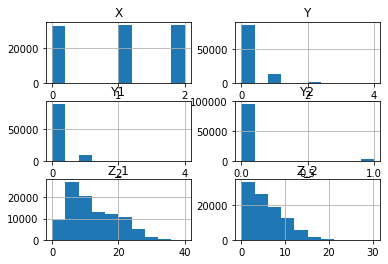

In [21]:
df.hist()

In [22]:
df.groupby('X').mean()['Y']

X
0    0.218307
1    0.137097
2    0.122980
Name: Y, dtype: float64

In [23]:
df.groupby('X').mean()[['Y1', 'Y2', 'Y']]

,Y1,Y2,Y
X,,,
0,0.203152,0.015155,0.218307
1,0.098363,0.038734,0.137097
2,0.052454,0.070525,0.122980


In [24]:
from statsmodels.api import OLS

df['expz2'] = np.exp(-z2/tau)
df['intercept'] = 1.
model = OLS(endog=df['Y'], exog=df[['expz2', 'Z_2', 'Z_1', 'X', 'intercept']])

result1 = model.fit()
df['y_given_z2_x'] = result1.predict()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     489.2
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:15:55   Log-Likelihood:                -48851.
No. Observations:              100000   AIC:                         9.771e+04
Df Residuals:                   99995   BIC:                         9.776e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
expz2          0.1174      0.014      8.255      0.000       0.090       0.145
Z_2            0.0019      0.001      2.230      0.026       0.000       0.004
Z_1            0.0100      0.000     28.575      0.000       0.009       0.011
X              0.0032      0.004      0.836      0.403      -0.004       0.011
intercept     -0.0200      0.011     -1.763      0.078      -0.042       0.002
==============================================================================
Omnibus:                    48705.798   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           244768.136
Skew:                           2.417   Prob(JB):                         0.00
Kurtosis:                       8.947   Cond. No.                         203.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

p_z1_given_x = KDEMultivariateConditional(endog=df[['Z_1']], exog=df[['X']], 
                                          dep_type='c', indep_type='u', 
                                          bw='normal_reference')

In [32]:
p_z2_given_x = KDEMultivariateConditional(endog=df[['Z_2']], exog=df[['X']], 
                                          dep_type='c', indep_type='u', 
                                          bw='normal_reference')

In [33]:
df['p_z2_given_x'] = p_z2_given_x.pdf()
df['p_z1_given_x'] = p_z1_given_x.pdf()

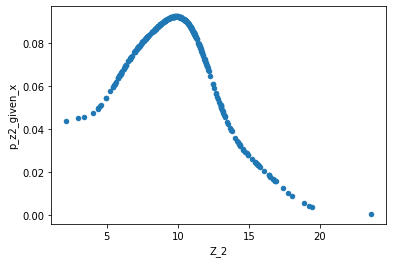

In [34]:
df[df.X==0].plot(x='Z_2', y='p_z2_given_x', kind='scatter')

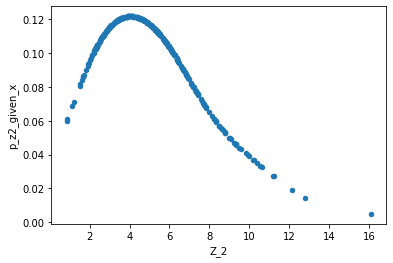

In [35]:
df[df.X==1].plot(x='Z_2', y='p_z2_given_x', kind='scatter')

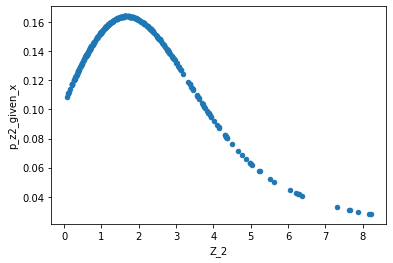

In [36]:
df[df.X==2].plot(x='Z_2', y='p_z2_given_x', kind='scatter')

In [ ]:
px = df.groupby('X').count()

In [ ]:
px / len(df)

In [9]:
from scipy.integrate import quad

def integrand(z1, x=0):
    f1 = float(p_z1_given_x.pdf(endog_predict=[z1], exog_predict=[x]))
    the_sum = 0.
    for xp in df.X.unique():
        y1 = 0.01*z1
        p_x = 1/3.
        the_sum += y1 * p_x
    return the_sum*f1
        
quad(lambda z: integrand(z, x=0.), 
         df.Z_1.min() - 1, 
         df.Z_1.max() + 1)

(0.1842450810858526, 7.67039182072342e-09)

In [10]:
quad(lambda z: integrand(z, x=1.), df.Z_1.min(), df.Z_1.max())

(0.10308931507159767, 1.1072909807926234e-08)

In [11]:
quad(lambda z: integrand(z, x=2.), df.Z_1.min(), df.Z_1.max())

(0.06284659882096293, 2.7160166945801733e-09)

In [12]:
from scipy.integrate import quad

def integrand(z2, x=0):
    f1 = float(p_z2_given_x.pdf(endog_predict=[z2], exog_predict=[x]))
    the_sum = 0.
    for xp in df.X.unique():
        y2 = 0.0782*np.exp(-z2/tau)
        p_x = 1/3.
        the_sum += y2 * p_x
    return the_sum*f1
        
quad(lambda z: integrand(z, x=0.), df.Z_2.min(), df.Z_2.max())

(0.016224279650751326, 1.0493377822568681e-08)

In [13]:
quad(lambda z: integrand(z, x=1.), df.Z_2.min(), df.Z_2.max())

(0.031625013111870735, 1.161733325338282e-08)

In [14]:
quad(lambda z: integrand(z, x=2.), df.Z_2.min(), df.Z_2.max())

(0.04645835823673856, 1.2403692951474178e-09)